### Курсовой проект Jupyter Notebook (Python) for Data Science

Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения,
которые были в курсе Python для Data Science. Градиентный бустинг изучается
в последующих курсах, поэтому в этом проекте его применять не следует.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy import stats

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
TRAIN_DATASET_PATH = 'Final course work/train.csv'
TEST_DATASET_PATH = 'Final course work/test.csv'

In [4]:
train = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)

In [5]:
train.shape[1]-1 == test.shape[1]

True

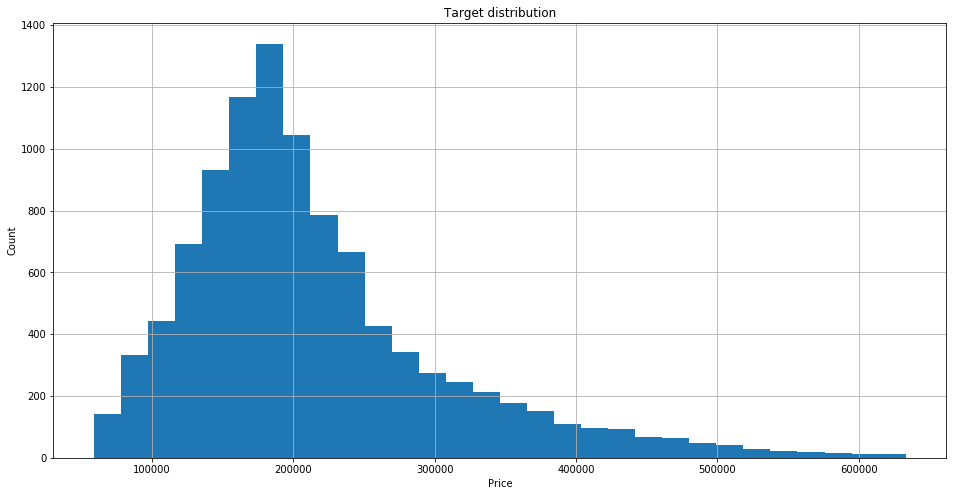

In [6]:
plt.figure(figsize = (16, 8))

train['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

### Предобработка массива train.csv

In [7]:
train.Ecology_2.replace(['A', 'B'], [0, 1], inplace=True)

In [8]:
train.Ecology_3.replace(['A', 'B'], [0, 1], inplace=True)

In [9]:
train.Shops_2.replace(['A', 'B'], [0, 1], inplace=True)

In [10]:
train.loc[train['LifeSquare'].isnull(),'LifeSquare']=train['LifeSquare'].mean() # Включение средней в пропущенные

In [11]:
train.loc[train.Healthcare_1.isnull(), 'Healthcare_1'] = train.Healthcare_1.mean() # Включение средней в пропущенные

In [12]:
train = train.drop('Id', 1)

### Предобработка массива test.csv

In [13]:
test.Ecology_2.replace(['A', 'B'], [0, 1], inplace=True)

In [14]:
test.Ecology_3.replace(['A', 'B'], [0, 1], inplace=True)

In [15]:
test.Shops_2.replace(['A', 'B'], [0, 1], inplace=True)

In [16]:
test.loc[test['LifeSquare'].isnull(),'LifeSquare']=test['LifeSquare'].mean() # Включение средней в пропущенные

In [17]:
test.loc[test.Healthcare_1.isnull(), 'Healthcare_1'] = test.Healthcare_1.mean() # Включение средней в пропущенные

In [18]:
test.drop(['Id'], axis = 1, inplace =True)

### БУДУТ ПОПРОБОВАНЫ ТРИ МОДЕЛИ

### Модель №1 с линейной регрессии (со всеми признаками)

In [19]:
X = train.drop('Price', 1)

In [20]:
y = pd.DataFrame(train.Price)

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [23]:
from sklearn.linear_model import LinearRegression

In [24]:
lr = LinearRegression()

In [25]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
y_pred = lr.predict(X_test)
y_pred.shape

(2500, 1)

In [27]:
check_test = pd.DataFrame({
    "y_test": y_test["Price"],
    "y_pred": y_pred.flatten(),
})

check_test.head(10)

,y_test,y_pred
6252,181530.459031,176308.266662
4684,260456.004692,257364.216803
1731,219945.304640,242290.309355
4742,66883.280318,98397.594414
4521,114086.065201,173570.074819
6340,359065.287230,330941.051481
576,377445.078933,243452.564710
5202,381912.162109,176419.926043
6363,133072.279471,105215.364381
439,184036.005146,177228.763466


In [28]:
from sklearn.metrics import r2_score as r2

In [29]:
y_pred_l=lr.predict(X_test)
print("R2:\t" + str(round(r2(y_test, y_pred_l), 3)))

R2:	0.451


Вывод по модели №1: Коэффициент детерминации R2 низкий (не выходит на 0.60)

### Смотрим, какие признаки являются определяющими

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [31]:
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)

X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

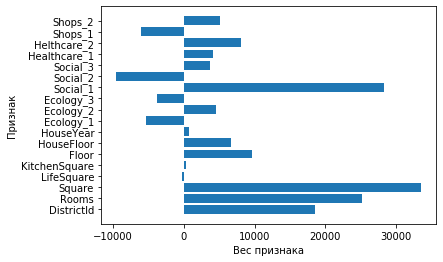

In [32]:
lr.fit(X_train_scaled, y_train)

plt.barh(X.columns, lr.coef_.flatten())

plt.xlabel("Вес признака")
plt.ylabel("Признак")

plt.show()

Примечание по весовым значениям признаков: "Очень странный и нелогичный большой вес у признака "Social_1" и низкий вес у "KitchenSquare" и "LifeSquare"

### Модель №2 с линейной регрессией (с приоритетными признакам))

In [33]:
XX = train[['DistrictId','Rooms','Square', 'LifeSquare', 'Ecology_1', 'Social_1', 'Helthcare_2', 'Shops_2']]

In [34]:
XX.describe().T

,count,mean,std,min,25%,50%,75%,max
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,209.000000
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,19.000000
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,641.065193
LifeSquare,10000.0,37.199645,76.588742,0.370619,25.527399,37.199645,41.427234,7480.592129
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,0.521867
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,74.000000
Helthcare_2,10000.0,1.319500,1.493601,0.000000,0.000000,1.000000,2.000000,6.000000
Shops_2,10000.0,0.917500,0.275139,0.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
XX_train, X_test, y_train, y_test = train_test_split(XX, y, test_size=0.25, random_state=21)

In [36]:
lr.fit(XX_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [37]:
y_predXX = lr.predict(X_test)
y_predXX.shape

(2500, 1)

In [38]:
check_test = pd.DataFrame({
    "y_test": y_test["Price"],
    "y_predXX": y_predXX.flatten(),
})
check_test.head(10)

,y_test,y_predXX
3644,93428.265205,130323.151175
1828,526817.563339,357450.763912
6661,130648.078594,123290.432746
9216,387464.467895,278919.705783
5911,181260.812655,208461.810666
7397,162406.699380,184669.584090
6403,148576.692687,174920.928349
11,165534.541425,258160.584828
4782,293992.262175,255509.493824
1327,118665.849413,115556.473145


In [39]:
from sklearn.metrics import r2_score as r2

In [40]:
print('r2:\t', round(r2(y_test, y_predXX), 3))

r2:	 0.46


Вывод по модели №2: Коэффициент детерминации r2 низкий (ниже требуемых 0.60)

## Модель №3 с RandomForest

In [41]:
from sklearn.ensemble import RandomForestRegressor

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [56]:
R_model = RandomForestRegressor()
R_model.fit(X_train,y_train.values.ravel())

y_pred_Rt=R_model.predict(X_test)

In [57]:
print('r2:\t', round(r2(y_test, y_pred_Rt), 3))

r2:	 0.7


Вывод по модели №3: коэффициент детерминации r2 равен от 0.682 до 0.712, то есть высокий. Модель №3 оценивается, как успешная и принимается в эксплуатацию.

### Итоговый csv-файл

In [45]:
y_pred_test=R_model.predict(test)

Выполняю требование, что "В файлах не должны содержаться индексы из датафрейма." и что csv-файл должен быть по образцу "Шаблон файла с предсказаниями.csv"

In [46]:
output = pd.DataFrame({'ID, Price' : y_pred_test})

In [47]:
output.reset_index(drop = True)

,"ID, Price"
0,158229.194388
1,234447.889070
2,161918.856709
3,395287.728382
4,138170.923659
5,209918.052312
6,171332.825606
7,213706.821055
8,278510.911929
9,208094.752522


В сдаваемом csv-файле один стоблец, так как в представленном шаблоне в материалах Урока 10 файл с одним столбцом  

In [48]:
output.to_csv('GLarin_predictions.csv', index = False)